# Libiraries

In [90]:
import os
import rasterio
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K


# Preprocessing

In [91]:
images_directory = '/kaggle/input/satellite-cellua/data/images'
labels_directory = '/kaggle/input/satellite-cellua/data/labels'

In [92]:
def load_images_and_labels(image_folder, label_folder):
    images = []
    labels = []
    
    for image_file in os.listdir(image_folder):
        if image_file.endswith('.tif'):
            image_path = os.path.join(image_folder, image_file)
            label_path = os.path.join(label_folder, image_file.replace('.tif', '.png'))
            
            with rasterio.open(image_path) as src:
                image = src.read()  # Shape: (12, 128, 128)
                
                # Transpose to shape (128, 128, 12)
                image = np.transpose(image, (1, 2, 0))
                
            label = np.array(Image.open(label_path))
            
            images.append(image)
            labels.append(label)
            
    
    # Normilization    
    images = np.array(images) / 255.0  
        
    return images, np.array(labels)

In [93]:
images, labels = load_images_and_labels(images_directory, labels_directory)

/opt/conda/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [94]:
def preprocess_labels(labels):
#     return (labels == 1).astype(np.uint8)
    return np.asarray(labels, dtype=np.float32)


labels = preprocess_labels(labels)


# Visulization

In [95]:
def visualize_raw_data(images, labels, num_images=5):
    for i in range(num_images):
        plt.figure(figsize=(10, 10))

        plt.subplot(4, 3, 1)
        rgb_image = np.stack([images[i][:, :, 3], images[i][:, :, 2], images[i][:, :, 1]], axis=-1)  # Red, Green, Blue channels
        rgb_image_normalized = rgb_image / np.max(rgb_image)
        plt.title("RGB Image")
        plt.imshow(rgb_image_normalized)
        plt.axis('off')

        # Display the Coastal Aerosol layer
        plt.subplot(4, 3, 2)
        plt.title("Coastal Aerosol Layer")
        plt.imshow(images[i][:, :, 0], cmap='gray')
        plt.axis('off')

        # Display the Water Occurrence Probability layer
        plt.subplot(4, 3, 3)
        plt.title("Water Occurrence Probability")
        plt.imshow(images[i][:, :, 11], cmap='hot')  # Last channel (index 11)
        plt.axis('off')

        # Display the NIR layer
        plt.subplot(4, 3, 4)
        plt.title("NIR Layer")
        plt.imshow(images[i][:, :, 4], cmap='gray')
        plt.axis('off')

        # Display the SWIR1 layer
        plt.subplot(4, 3, 5)
        plt.title("SWIR1 Layer")
        plt.imshow(images[i][:, :, 5], cmap='gray')
        plt.axis('off')

        # Display the SWIR2 layer
        plt.subplot(4, 3, 6)
        plt.title("SWIR2 Layer")
        plt.imshow(images[i][:, :, 6], cmap='gray')
        plt.axis('off')

        # Display the QA Band layer
        plt.subplot(4, 3, 7)
        plt.title("QA Band Layer")
        plt.imshow(images[i][:, :, 7], cmap='gray')
        plt.axis('off')

        # Display the Merit DEM layer
        plt.subplot(4, 3, 8)
        plt.title("Merit DEM Layer")
        plt.imshow(images[i][:, :, 8], cmap='gray')
        plt.axis('off')

        # Display the Copernicus DEM layer
        plt.subplot(4, 3, 9)
        plt.title("Copernicus DEM Layer")
        plt.imshow(images[i][:, :, 9], cmap='gray')
        plt.axis('off')

        # Display the ESA World Cover Map layer
        plt.subplot(4, 3, 10)
        plt.title("ESA World Cover Map")
        plt.imshow(images[i][:, :, 10], cmap='gray')
        plt.axis('off')

        # Display the Ground Truth label
        plt.subplot(4, 3, 11)
        plt.title("Ground Truth")
        plt.imshow(labels[i], cmap='gray')
        plt.axis('off')

        plt.show()



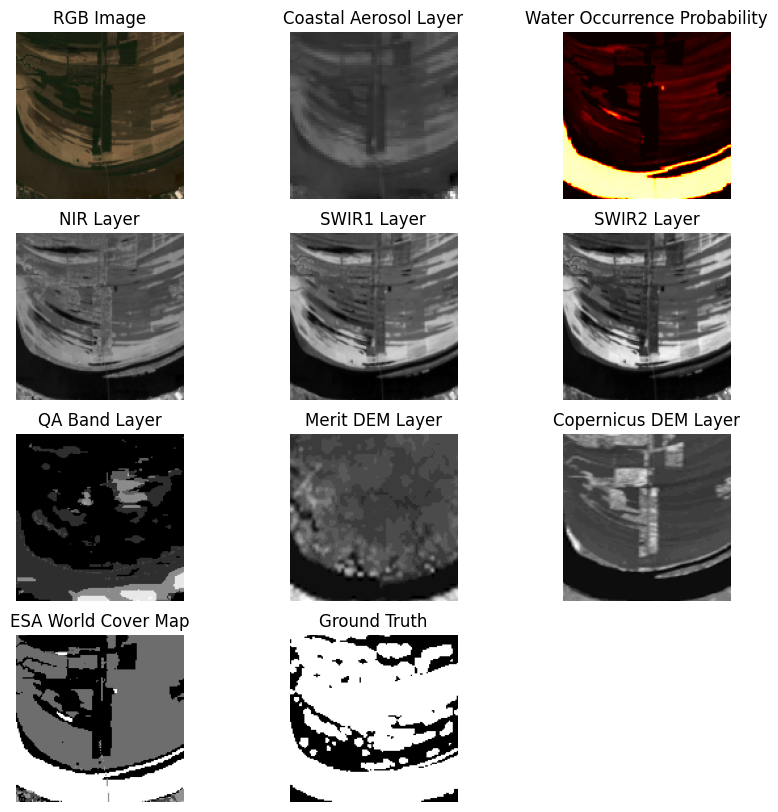

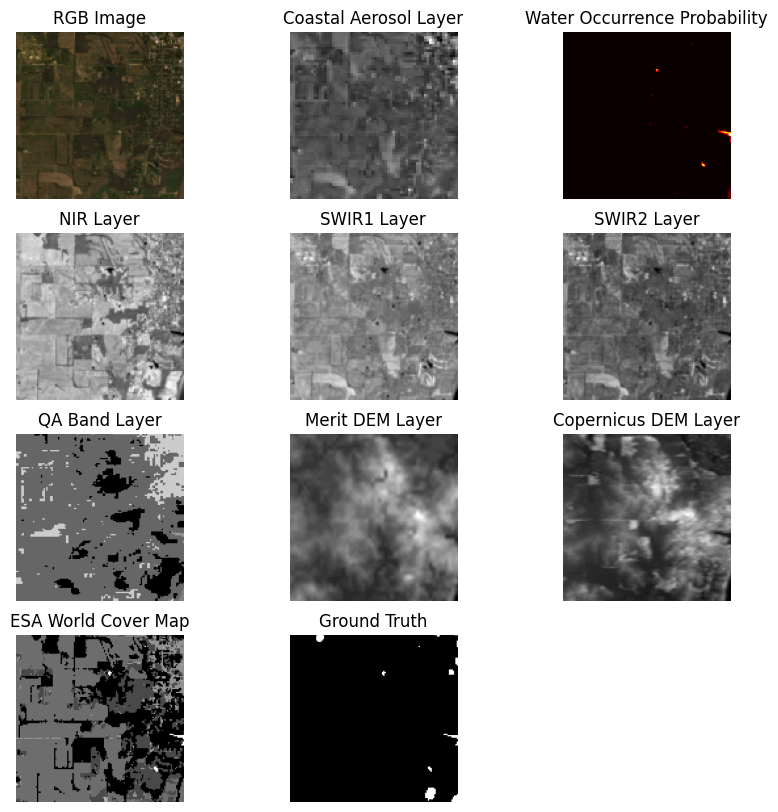

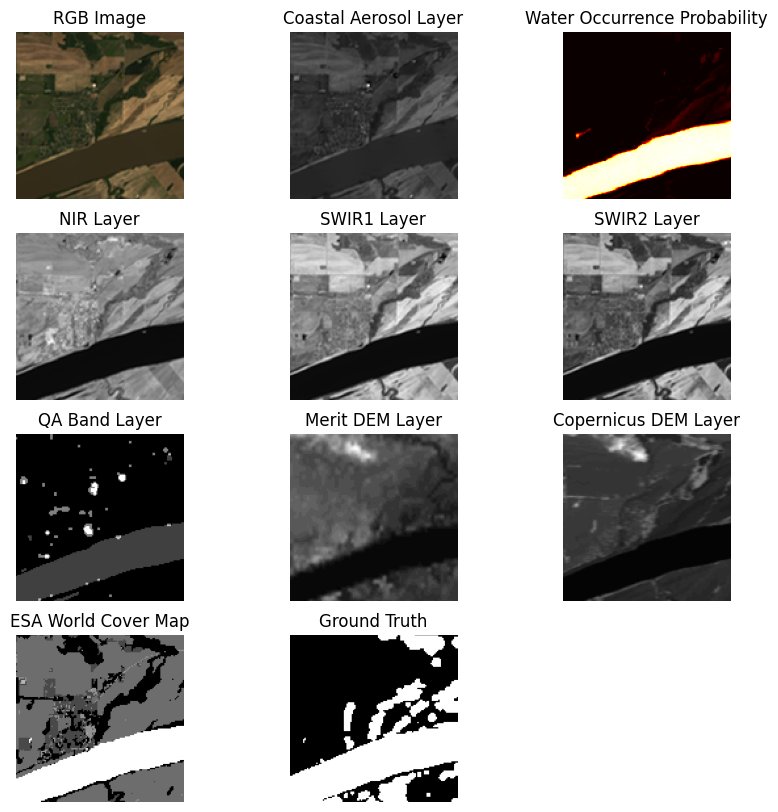

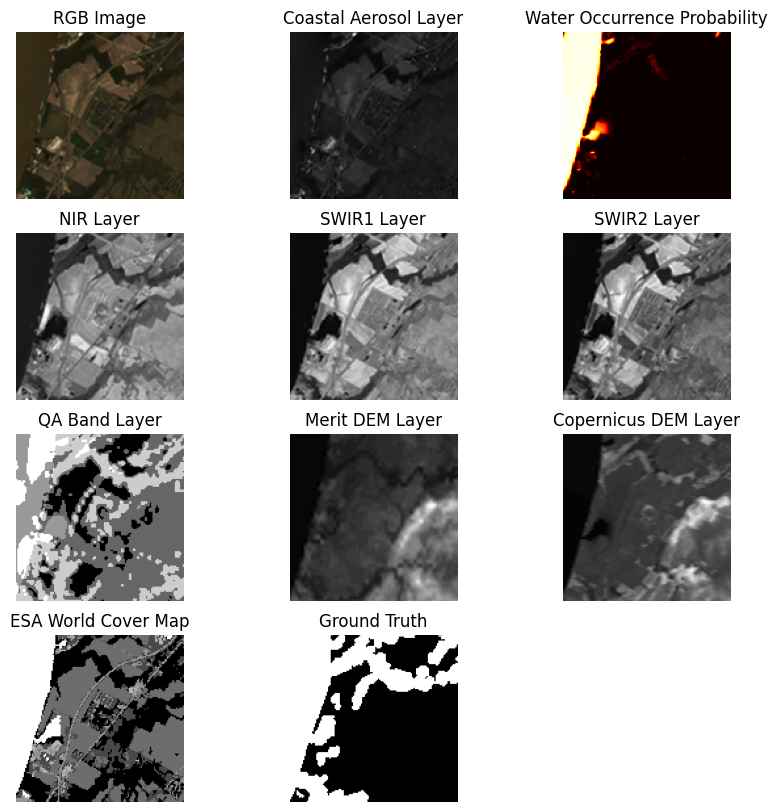

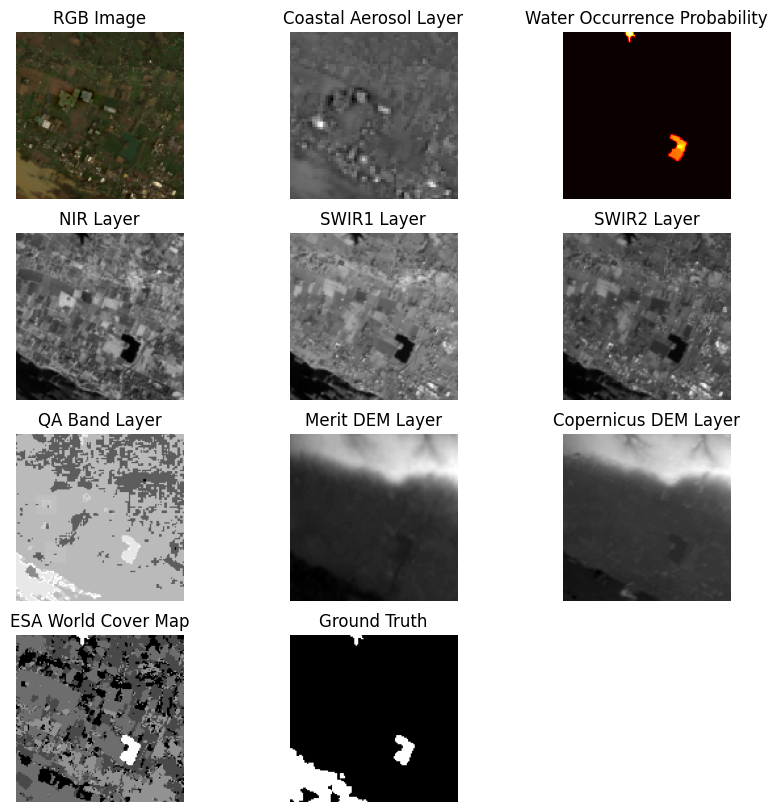

In [96]:
visualize_raw_data(images, labels)

# Split Data

In [97]:
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Utils

In [98]:
def visualize_predictions(model, X_test, y_test, num_images=5):
    predictions = model.predict(X_test)
    
    for i in range(num_images):
        plt.figure(figsize=(10, 10))

        plt.subplot(1, 3, 1)
        plt.title("Input Image")
        plt.imshow(X_test[i][:, :, 3], cmap='gray')

        plt.subplot(1, 3, 2)
        plt.title("Ground Truth")
        plt.imshow(y_test[i], cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(predictions[i] > 0.5, cmap='gray')

        plt.show()

In [99]:
def iou_metric(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred > 0.5, 'float32')  # For binary classification, thresholding at 0.5
    
    # Flatten the tensors to ensure the shapes match
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    intersection = K.sum(K.abs(y_true * y_pred))
    union = K.sum(K.abs(y_true) + K.abs(y_pred)) - intersection
    iou = (intersection + K.epsilon()) / (union + K.epsilon())
    
    return iou


In [100]:
def precision_metric(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred > 0.5, 'float32')  # Convert predictions to binary
    
        # Flatten the tensors to ensure the shapes match
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    true_positives = K.sum(y_true * y_pred)
    predicted_positives = K.sum(y_pred)
    precision = true_positives / (predicted_positives + K.epsilon())
    
    return precision

def recall_metric(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred > 0.5, 'float32')  # Convert predictions to binary
    
        # Flatten the tensors to ensure the shapes match
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    true_positives = K.sum(y_true * y_pred)
    actual_positives = K.sum(y_true)
    recall = true_positives / (actual_positives + K.epsilon())
    
    return recall

def f1_metric(y_true, y_pred):
    precision = precision_metric(y_true, y_pred)
    recall = recall_metric(y_true, y_pred)
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    
    return f1


# Build and train the model

In [101]:
import tensorflow as tf
from tensorflow.keras import layers, models

def unet_model(input_size=(128, 128, 12)):
    inputs = layers.Input(input_size)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Decoder
    up4 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv3)
    concat4 = layers.concatenate([up4, conv2])
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(concat4)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up5 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv4)
    concat5 = layers.concatenate([up5, conv1])
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(concat5)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv5)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy',iou_metric,precision_metric, recall_metric, f1_metric])


In [102]:
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_val, y_val))

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 251ms/step - accuracy: 0.7760 - f1_metric: 0.4025 - iou_metric: 0.2865 - loss: 0.5254 - precision_metric: 0.5636 - recall_metric: 0.3596 - val_accuracy: 0.9074 - val_f1_metric: 0.8067 - val_iou_metric: 0.6772 - val_loss: 0.2526 - val_precision_metric: 0.9401 - val_recall_metric: 0.7069
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.8897 - f1_metric: 0.7523 - iou_metric: 0.6116 - loss: 0.3255 - precision_metric: 0.9029 - recall_metric: 0.6524 - val_accuracy: 0.9025 - val_f1_metric: 0.8125 - val_iou_metric: 0.6857 - val_loss: 0.3104 - val_precision_metric: 0.8637 - val_recall_metric: 0.7674
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.8844 - f1_metric: 0.7425 - iou_metric: 0.5978 - loss: 0.3018 - precision_metric: 0.8733 - recall_metric: 0.6535 - val_accuracy: 0.9171 - val_f1_metric: 0.8356 - val_iou_metric: 0.7206 - val_loss: 0.2518 - val_precision_metric: 0.9191 - val_recall_metric: 0.7682
Epoch 4/100
14/

# Evaluation

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step


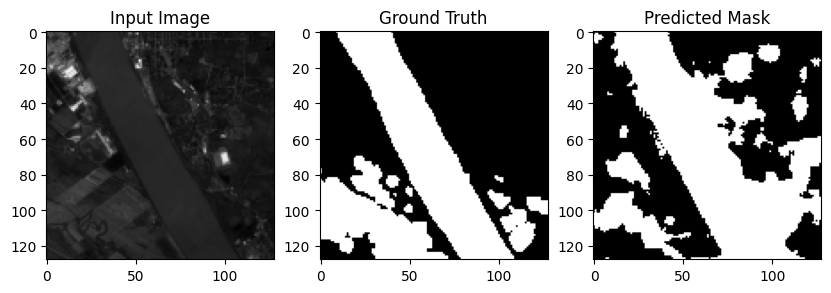

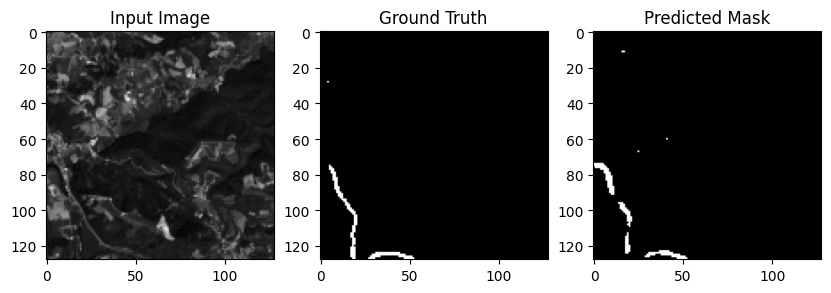

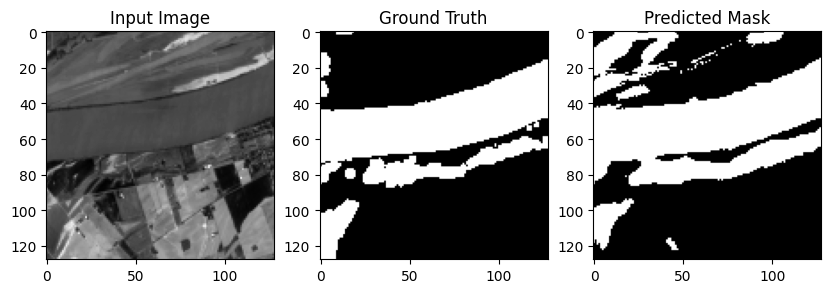

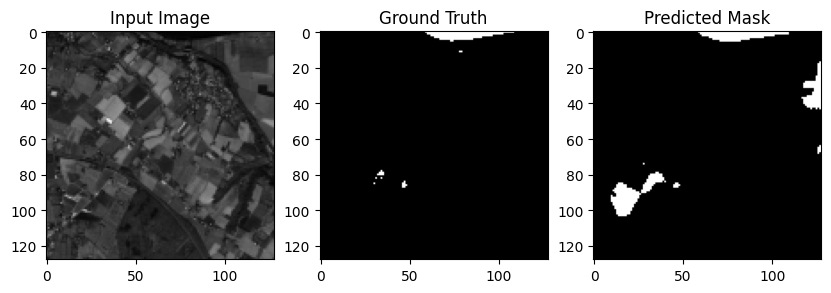

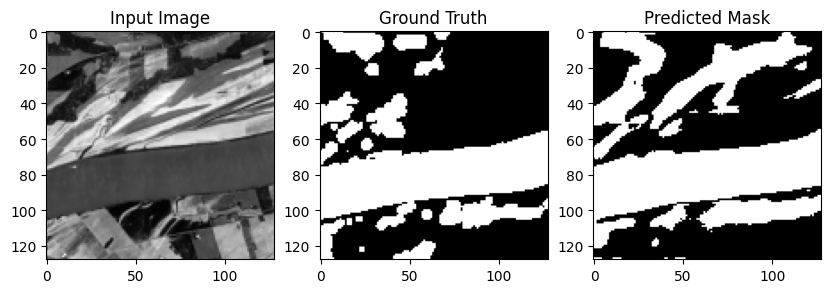

In [103]:
visualize_predictions(model, X_test, y_test)

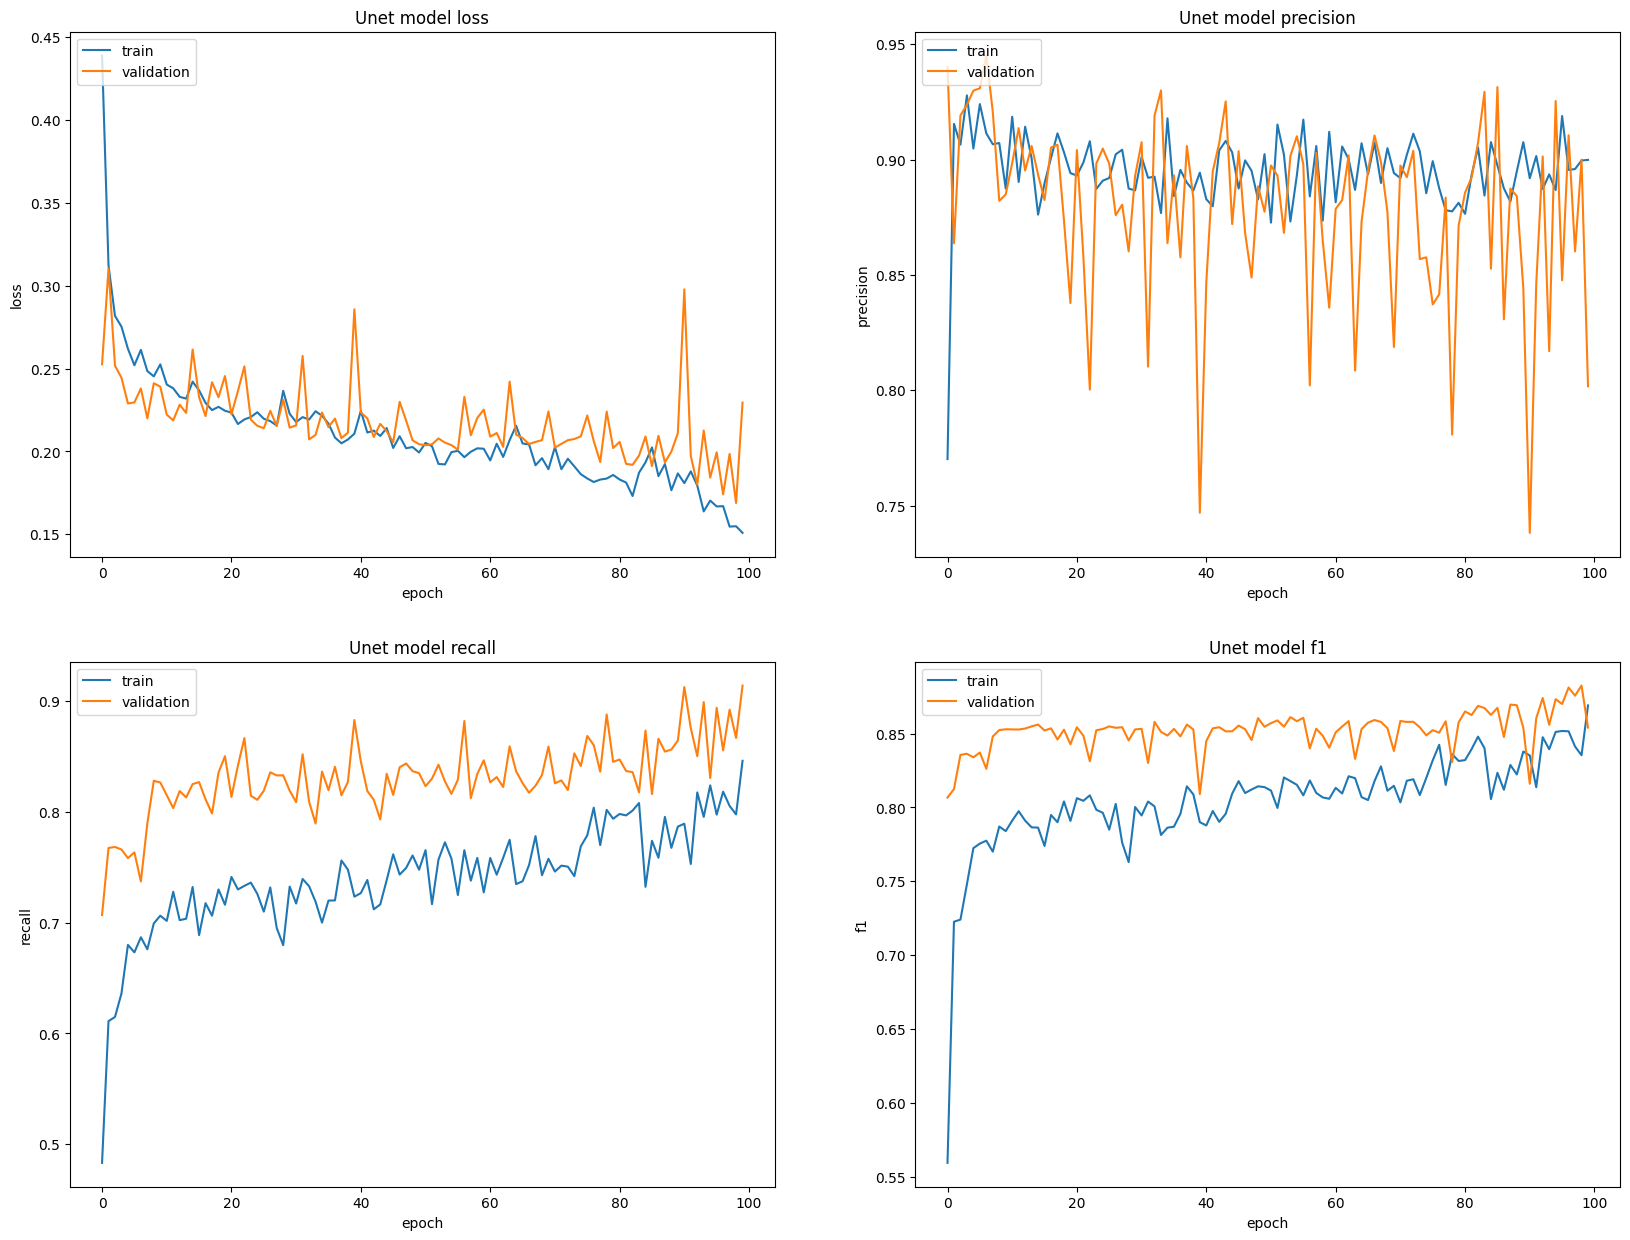

In [104]:
fig,((ax11,ax12),(ax13,ax14)) = plt.subplots(2,2,figsize=(20,15))
ax11.plot(history.history['loss'])
ax11.plot(history.history['val_loss'])
ax11.title.set_text('Unet model loss')
ax11.set_ylabel('loss')
ax11.set_xlabel('epoch')
ax11.legend(['train', 'validation'], loc='upper left')

ax12.plot(history.history['precision_metric'])
ax12.plot(history.history['val_precision_metric'])
ax12.set_title('Unet model precision')
ax12.set_ylabel('precision')
ax12.set_xlabel('epoch')
ax12.legend(['train', 'validation'], loc='upper left')

ax13.plot(history.history['recall_metric'])
ax13.plot(history.history['val_recall_metric'])
ax13.set_title('Unet model recall')
ax13.set_ylabel('recall')
ax13.set_xlabel('epoch')
ax13.legend(['train', 'validation'], loc='upper left')

ax14.plot(history.history['f1_metric'])
ax14.plot(history.history['val_f1_metric'])
ax14.set_title('Unet model f1')
ax14.set_ylabel('f1')
ax14.set_xlabel('epoch')
ax14.legend(['train', 'validation'], loc='upper left')

In [105]:
model.evaluate(X_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9142 - f1_metric: 0.8529 - iou_metric: 0.7439 - loss: 0.2015 - precision_metric: 0.8200 - recall_metric: 0.8887 


[0.20446671545505524,
 0.9129094481468201,
 0.7356351613998413,
 0.8139878511428833,
 0.8837954998016357,
 0.8474500179290771]